In [6]:
import os
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
from sklearn.metrics import cohen_kappa_score
from scipy import stats

In [2]:
def compute_anova(df, dependent_v):
    """

    Args:
        df: data frame that contains the data
        dependent_v: dependent variable

    Returns:

    """
    aov = pg.mixed_anova(dv=dependent_v, within='mode', between='condition', subject='id', data=df)
    # printing of ANOVA summary
    pg.print_table(aov)


In [3]:
def check_assumptions(df, dv, dv_name):
    '''
    Checks the assumptions of a mixed ANOVA.

    df (pd.DataFrame)
    dv (str): dependent variable column name
    dv_name (str): name of the dependent variable (to be printed)
    '''

    print("Checking the assumptions for the dependent variable {}...\n".format(dv_name))
    all_assumptions = []

    # Assumption of the residuals being normally distributed
    df['factor_comb'] = df["condition"] + '-'+ df["mode"]
    normal = pg.normality(data=df, dv=dv, group='factor_comb')
    if normal["normal"].all():
        print("The residuals are approximately normally distributed for each level of the within-subjects factor (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(True)
    else:
        print("The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)")
        all_assumptions.append(False)

    print()
    # Assumption of homoscedasticity
    print("There should be equal variance for every level of within-subject factor:")
    hybrid = df[df["mode"]=="Hybrid"].reset_index(drop=True)
    homo_hybrid = pg.homoscedasticity(data=hybrid, dv=dv, group='condition')
    all_assumptions.append(homo_hybrid["equal_var"][0])
    print("For the level Hybrid, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_hybrid["pval"][0].round(3), homo_hybrid["equal_var"][0]))

    fp = df[df["mode"]=="Firstperson"].reset_index(drop=True)
    homo_fp = pg.homoscedasticity(data=fp, dv=dv, group='condition')
    all_assumptions.append(homo_fp["equal_var"][0])
    print("For the level First Person, Levene's test resulted in a p-value of {}, indicating that the assumption of equal variances is {}.".format(homo_fp["pval"][0].round(3), homo_fp["equal_var"][0]))

    print()
    # Assumption of sphericity
    sphericity = pg.sphericity(data=df, dv=dv, subject='id', within='condition')
    all_assumptions.append(sphericity[0])
    print("Mauchly’s test of sphericity resulted in a p-value of {}, indicating that the assumption is {}.".format(sphericity[-1], sphericity[0]))

    print()
    # Assumption of homogeneity of the variance-covariance matrices:
    print("The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:")
    box_fp = pg.box_m(data=fp, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_fp["equal_cov"][0])
    print("For the level First Person, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_fp["pval"][0].round(3), box_fp["equal_cov"][0]))

    box_hybrid = pg.box_m(data=hybrid, dvs=[dv], group='condition', alpha=0.001)
    all_assumptions.append(box_hybrid["equal_cov"][0])
    print("For the level Hybrid, Box’s M test resulted in a p-value of {}, indicating that the assumption is {}.".format(box_hybrid["pval"][0].round(3), box_hybrid["equal_cov"][0]))

    print()
    # Assumption of no outliers
    #outliers = df[df[dv] > df[dv].mean() + 3 * df[dv].std()]
    outliers = df[np.abs(df[dv] - df[dv].mean()) > (3 * df[dv].std())]
    print("A data point is called an outlier if it > 3 sd away from the mean.")
    if outliers.empty:
        print("There are no outliers!")
        all_assumptions.append(True)
    else:
        print("There are outliers! The outliers are the participants {}".format(outliers["id"].values))
        print(outliers)
        all_assumptions.append(False)


    if all(x == True for x in all_assumptions):
        print()
        print("ALL ASSUMPTIONS ARE TRUE!")

In [5]:
#/home/yesid/Documents/Master_semester3/VR/text_analysis_task/clean_transcription/joined_ratings.csv
#path to csv file with transcriptions and joned ratings
file_transcription= input()
df_transcription = pd.read_csv(file_transcription)

## Cohen's Kappa
### Rating transcriptions:
- Transcriptions were anonymized so that raters did not know what condition, mode or id a transcription belonged to.
- Raters were handed out a csv file with a sample of the transcriptions. This file contained two columns:
    - id_transcription: a coded representation of the id, condition and mode. (Raters did not know what this code stood for.)
    - transcription: text with the audio file transcription.
    - rating: raters fill out this column with any of the following:
        - 0: which stood for undefined. The transcription was neither first person nor third person.
        - 1: which stood for first person.
        -  3: which stood for third person.

- The rating process was carried out in two iterations:
    - Iteration 1: raters were handed out samples of the transcriptions.
    - Iteration 2: raters were handed out a **different** sample of the transcriptions.

In this section we will use Cohen's Kappa to measure the inter-raters agreement.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html


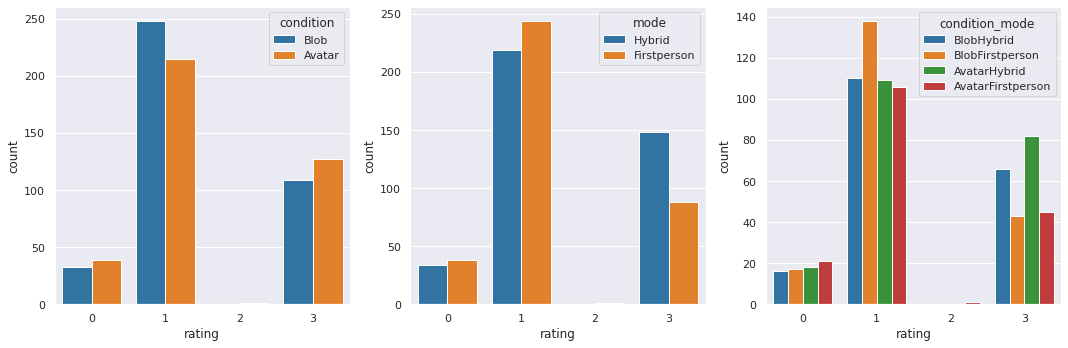

In [67]:
def plots_transcription (df_description):
    """
    Gives an overview of the transcription data
    Args:
        df_description: data frame with the transcription and respective ratings

    Returns:

    """
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131)
    sns.countplot(x="rating", hue='condition',palette="tab10", data=df_transcription,  ax=ax1)
    ax2 = fig.add_subplot(132)
    sns.countplot(x="rating", hue='mode',palette="tab10", data=df_transcription, ax=ax2)
    ax3 = fig.add_subplot(133)
    sns.countplot(x="rating", hue='condition_mode',palette="tab10", data=df_transcription, ax=ax3)


    plt.tight_layout()

plots_transcription(df_transcription)

The effect of the condition/treatment on the dependent variable -- whether someone is speaking in first, third person or undefined-- does or does not depend on the mode.

In [12]:
check_assumptions(df_transcription,'rating','rating')

Checking the assumptions for the dependent variable rating...

The residuals are NOT approximately normally distributed for each level of the within-subjects factor! (tested using the Shapiro-Wilks Test)

There should be equal variance for every level of within-subject factor:
For the level Hybrid, Levene's test resulted in a p-value of 0.289, indicating that the assumption of equal variances is True.
For the level First Person, Levene's test resulted in a p-value of 0.15, indicating that the assumption of equal variances is True.

Mauchly’s test of sphericity resulted in a p-value of 1.0, indicating that the assumption is True.

The homogeneity of variance-covariance matrices formed by the between-subject factor for each level of the within-subject factor should be equal:
For the level First Person, Box’s M test resulted in a p-value of 0.205, indicating that the assumption is True.
For the level Hybrid, Box’s M test resulted in a p-value of 0.646, indicating that the assumption is Tr

In [4]:
aov = pg.mixed_anova(dv='rating', within='mode', between='condition', subject='id', data=df_transcription)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
condition    0.281      1     81  0.281   0.432    0.513  0.005  nan
mode         3.086      1     81  3.086  12.827    0.001  0.137    1.000
Interaction  0.006      1     81  0.006   0.024    0.877  0.000  nan

